This notebook generates sources and sinks for people in Canberra.

In [204]:
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import shapely.geometry as geo
import math
import numpy as np
import random
import matplotlib.colors

In [6]:
land_use = gpd.read_file('../data/act_land_use.geojson')

In [40]:
land_use_types = set(land_use.LAND_USE_POLICY_DESC)

In [41]:
land_use_types

{'BROADACRE',
 'BUSINESS ZONE',
 'COMMUNITY FACILITIES',
 'CORE ZONE',
 'DESIGNATED',
 'GENERAL INDUSTRY',
 'HIGH DENSITY RESIDENTIAL',
 'HILLS, RIDGES AND BUFFER AREAS',
 'INDUSTRIAL MIXED USE',
 'LEISURE AND ACCOMMODATION',
 'LOCAL CENTRE',
 'MEDIUM DENSITY RESIDENTIAL',
 'MIXED USE',
 'MOUNTAINS AND BUSHLANDS',
 'RESTRICTED ACCESS RECREATION ZONE',
 'RIVER CORRIDOR',
 'RURAL',
 'SERVICES',
 'SERVICES ZONE',
 'SUBURBAN',
 'SUBURBAN CORE',
 'TRANSPORT',
 'URBAN OPEN SPACE',
 'URBAN RESIDENTIAL'}

We will also need the census SA1 region data.

In [7]:
census = gpd.read_file('../data/G01_ACT_GDA2020.gpkg', layer=6)

Spatially combine these.

In [8]:
overlay = gpd.overlay(land_use, census.to_crs(land_use.crs))

This lets us add zoning to each SA1.

In [16]:
overlay_grouped = overlay.groupby('SA1_CODE_2021')

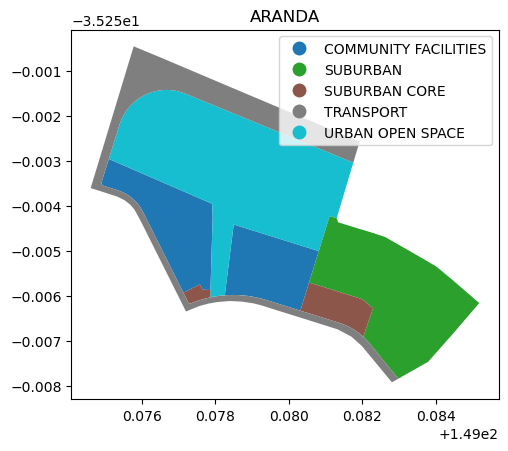

In [35]:
for sa1, ol in overlay_grouped:
    ol.plot(column='LAND_USE_POLICY_DESC', legend=True)
    plt.title(ol.DIVISION_NAME.iloc[0])
    plt.show()
    break

This is very cool. Let's use it to assign population to each subregion. We'll assume that population density is constant within an SA1.

In [78]:
residential_policies = {
 'HIGH DENSITY RESIDENTIAL',
 'MEDIUM DENSITY RESIDENTIAL',
 'MIXED USE',
 'RURAL',
 'SUBURBAN',
 'SUBURBAN CORE',
 'URBAN RESIDENTIAL',
 'CORE ZONE',  # mainly for Civic
}
residential_objectids = {4396, 4283}  # UC, ANU
all_residentials = []
for sa1, ol in tqdm(overlay_grouped):
    pop = ol.Tot_P_P.iloc[0]  # all should be the same within an SA1
    residentials = ol[ol.LAND_USE_POLICY_DESC.isin(residential_policies) |
                      ol.OBJECTID.isin(residential_objectids)].reset_index()
    if len(residentials) == 0:
        continue
    residential_pcs = residentials.to_crs('EPSG:3577').area / residentials.to_crs('EPSG:3577').unary_union.area
    residential_pops = (pop * residential_pcs).round().astype(int)
    residentials['pop'] = residential_pops
    all_residentials.append(residentials)

100%|██████████████████████████████████████████████████████████████████████████████| 1227/1227 [01:43<00:00, 11.90it/s]


In [79]:
all_residentials = gpd.pd.concat(all_residentials)

In [237]:
all_residentials.reset_index(inplace=True)

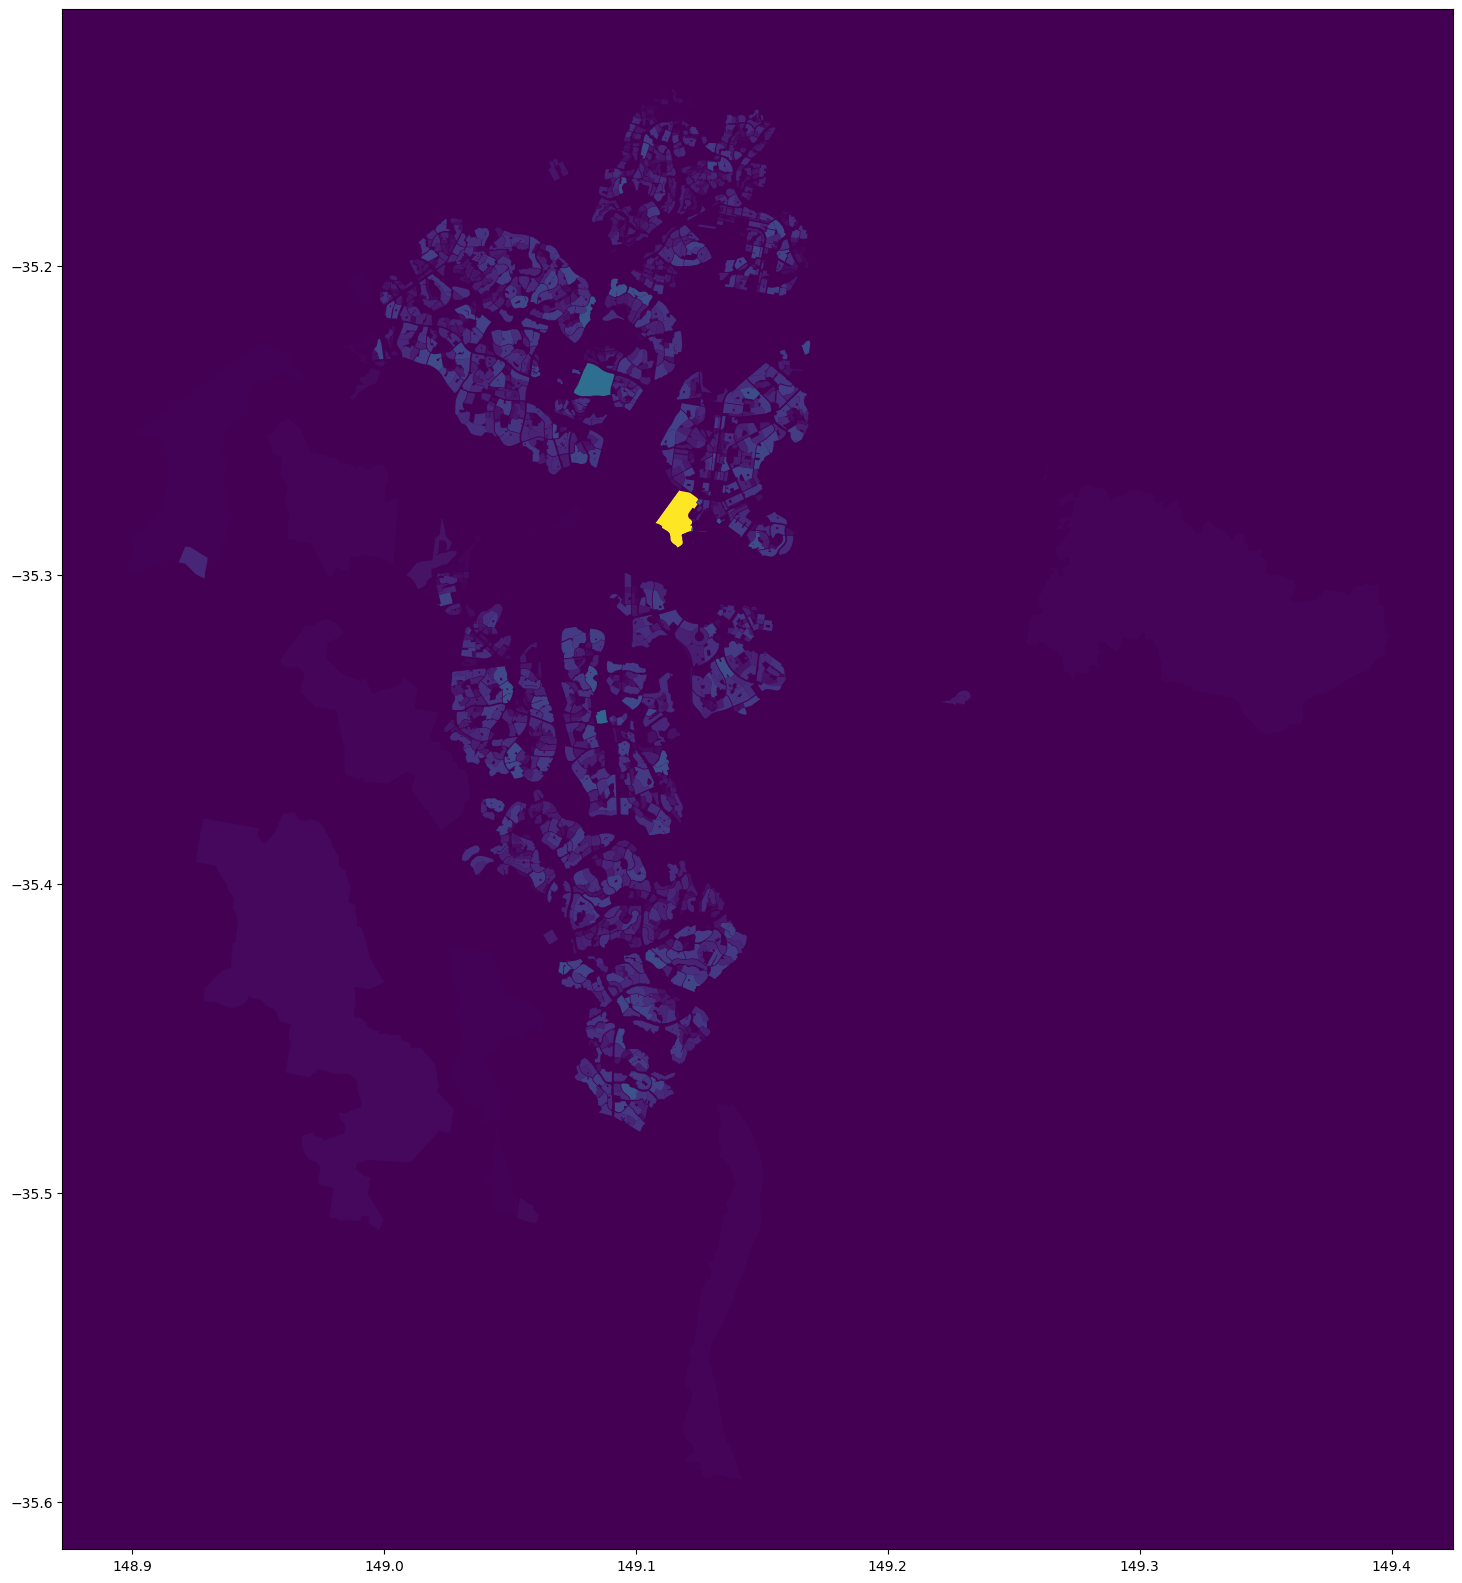

In [238]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot()
all_residentials.plot(column='pop', ax=ax)
ax.set_facecolor(plt.colormaps.get('viridis').colors[0])

Now let's let people go to commercial zones.

In [209]:
commercial_zones = {
 'BUSINESS ZONE',
 'COMMUNITY FACILITIES',
 'CORE ZONE',
 'DESIGNATED',
 'GENERAL INDUSTRY',
 'INDUSTRIAL MIXED USE',
 'LEISURE AND ACCOMMODATION',
 'LOCAL CENTRE',
 'MIXED USE',
 'SERVICES',
 'SERVICES ZONE',
}
all_commercials = []
for sa1, ol in tqdm(overlay_grouped):
    pop = ol.Tot_P_P.iloc[0]  # all should be the same within an SA1
    commercials = ol[ol.LAND_USE_POLICY_DESC.isin(commercial_zones)].reset_index()
    if len(commercials) == 0:
        continue
    all_commercials.append(commercials)
all_commercials = gpd.pd.concat(all_commercials)
all_commercials.reset_index(inplace=True)

100%|█████████████████████████████████████████████████████████████████████████████| 1227/1227 [00:05<00:00, 205.46it/s]


<AxesSubplot:>

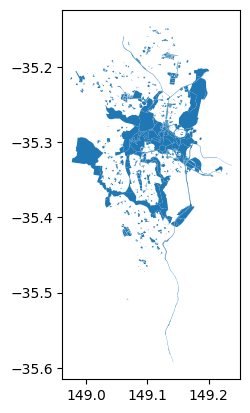

In [84]:
all_commercials.plot()

We now have sources and destinations. Let's start with a really simple model where people try to get to a random commercial area at a particular time, from their house which is a fixed location. They spend a random amount of time there and then go home.

In [240]:
sa1.to_dict()

{'index': 10451,
 'OBJECTID': 4302,
 'ID': 5573.0,
 'LAND_USE_ZONE_CODE_ID': 'NUZ2',
 'LAND_USE_POLICY_DESC': 'RURAL',
 'VARIATION_YEAR': '08',
 'GAZETTAL_NUMBER': 'NI2008-27',
 'GAZETTAL_DATE': Timestamp('2008-03-31 00:00:00'),
 'DIVISION_SHORT': None,
 'DIVISION_CODE': nan,
 'DIVISION_NAME': None,
 'DISTRICT_SHORT': 'PADD',
 'DISTRICT_CODE': 16,
 'DISTRICT_NAME': 'PADDYS RIVER',
 'LIFECYCLE_STAGE': 'GAZETTED',
 'SHAPE_Length': 55469.20672935885,
 'SHAPE_Area': 56068955.96120888,
 'SA1_CODE_2021': '80111114101',
 'SA1_NAME_2021': '80111114101',
 'Tot_P_M': 42,
 'Tot_P_F': 26,
 'Tot_P_P': 63,
 'Age_0_4_yr_M': 10,
 'Age_0_4_yr_F': 7,
 'Age_0_4_yr_P': 14,
 'Age_5_14_yr_M': 4,
 'Age_5_14_yr_F': 0,
 'Age_5_14_yr_P': 6,
 'Age_15_19_yr_M': 3,
 'Age_15_19_yr_F': 0,
 'Age_15_19_yr_P': 9,
 'Age_20_24_yr_M': 0,
 'Age_20_24_yr_F': 0,
 'Age_20_24_yr_P': 0,
 'Age_25_34_yr_M': 4,
 'Age_25_34_yr_F': 9,
 'Age_25_34_yr_P': 11,
 'Age_35_44_yr_M': 4,
 'Age_35_44_yr_F': 0,
 'Age_35_44_yr_P': 0,
 'Age_45_5

In [246]:
people = []
sources = []
downscale_factor = 10
for idx, sa1 in tqdm(all_residentials.iterrows(), total=len(all_residentials)):
    for i in range(sa1['pop'] // downscale_factor):
        dest = random.choice(all_commercials.index)
        person = {
            'home': idx,
            'work': dest,
            'arrival_time': int(np.random.normal(loc=8.5 * 60 * 60, scale=0.5 * 60 * 60)),
            'duration': int(np.random.normal(loc=7 * 60 * 60, scale=2 * 60 * 60)),
        }
        people.append(person)
    sources.append({
        'id': idx,
        'lon': round(sa1.geometry.centroid.x, 6),
        'lat': round(sa1.geometry.centroid.y, 6),
        'name': sa1.DIVISION_NAME if sa1.DIVISION_NAME else sa1.DISTRICT_NAME
    })

100%|████████████████████████████████████████████████████████████████████████████| 3410/3410 [00:01<00:00, 3094.36it/s]


In [247]:
dests = []
for idx, dest in tqdm(all_commercials.iterrows()):
    dests.append({
        'id': idx,
        'lon': round(dest.geometry.centroid.x, 6),
        'lat': round(dest.geometry.centroid.y, 6),
        'name': dest.DIVISION_NAME if dest.DIVISION_NAME else dest.DISTRICT_NAME
    })

1906it [00:00, 5055.46it/s]


In [248]:
import json
with open('../data/allpops.json', 'w') as f:
    json.dump({
        'people': people,
        'sources': sources,
        'destinations': dests,
    }, f)

Next we need to estimate how often people actually want to go to the destinations. We'll use the hourly boarding and alighting data.

In [86]:
boardings = gpd.pd.read_csv('../data/Boardings_By_Stop_By_Hr.csv')
alightings = gpd.pd.read_csv('../data/Alightings_By_Stop_By_Hr.csv')

In [106]:
boarding_locations = [geo.Point(149.0296370117712, -35.33102421415854)]  # Warragamba Av before Eucumbene Dr - 2565.
default_location = [149.1286518321313, -35.28204004319159]  # City Hill
for _, b in boardings.iloc[1:].iterrows():
    if b['Stop ID'] == 1609:
        # St Edmunds College McMillan Cr SSO
        location = [149.1460337851055, -35.32321387696771]
    elif b['Stop ID'] == 1649:
        # Lawrence Wackett Cr before Tharwa Dr
        location = [149.1226405665382, -35.44264570526669]
    elif b['Stop ID'] == 4003:
        # Canberra HS Bowman St SSO
        location = [149.072070879909, -35.251676390416264]
    elif b['Stop ID'] == 5123:
        # Covenant College School Grounds SSO
        location = [149.09022226964356, -35.43952672133115]
    elif b['Stop ID'] == 4930:
        # Doesn't exist
        location = default_location
    elif b['Stop ID'] == 5555:
        # Doesn't exist
        location = default_location
    elif math.isnan(b['Stop ID']):
        # Doesn't exist
        location = default_location
    else:
        try:
            location = [float(s) for s in b.Location.strip('()').split(', ')][::-1]
        except AttributeError:
            print(b)
    boarding_locations.append(geo.Point(*location))

boardings_ = gpd.GeoDataFrame(boardings, geometry=boarding_locations)
boardings_ = boardings_[boardings_['Stop ID'].notnull()]

In [140]:
alighting_locations = []
default_location = [149.1286518321313, -35.28204004319159]  # City Hill
for _, b in alightings.iterrows():
    if b['Stop ID'] == 2565:
        # Warragamba Av before Eucumbene Dr - 2565.
        location = [149.0296370117712, -35.33102421415854]
    elif b['Stop ID'] == 1609:
        # St Edmunds College McMillan Cr SSO
        location = [149.1460337851055, -35.32321387696771]
    elif b['Stop ID'] == 1649:
        # Lawrence Wackett Cr before Tharwa Dr
        location = [149.1226405665382, -35.44264570526669]
    elif b['Stop ID'] == 4003:
        # Canberra HS Bowman St SSO
        location = [149.072070879909, -35.251676390416264]
    elif b['Stop ID'] == 5123:
        # Covenant College School Grounds SSO
        location = [149.09022226964356, -35.43952672133115]
    elif b['Stop ID'] == 4930:
        # Doesn't exist
        location = default_location
    elif b['Stop ID'] == 5555:
        # Doesn't exist
        location = default_location
    elif math.isnan(b['Stop ID']):
        # Doesn't exist
        location = default_location
    else:
        try:
            location = [float(s) for s in b.Location.strip('()').split(', ')][::-1]
        except AttributeError:
            print(b)
    alighting_locations.append(geo.Point(*location))

alightings_ = gpd.GeoDataFrame(alightings, geometry=alighting_locations)
alightings_ = alightings_[alightings_['Stop ID'].notnull()]

Let's say that each bus stop is used to access the km around it. So if an SA1 is within 1 km of a bus stop, people want to go there. People will alight to places nearby using a Gaussian model with 1 stdev = 0.5 km.

We need a bus stop -> SA1 weighting map. Each set of bus stop weights will add to 1. We will also have to do this for not just commercial but residential too, since people will go home... this is hard to think about.

In [158]:
census_okgeom = census[census.geometry.notnull()].to_crs('EPSG:3577')

In [167]:
boardings_.set_crs('EPSG:4326', inplace=True);
alightings_.set_crs('EPSG:4326', inplace=True);

In [201]:
stop_to_sa1_weights = {}  # stop -> {sa1 -> weight}
for _, stop in tqdm(alightings_.to_crs('EPSG:3577').iterrows()):
    distances_km = census_okgeom.geometry.apply(lambda g: stop.geometry.distance(g.boundary)) / 1000
    gaussian = np.exp(-distances_km ** 2 / (2 * 0.5 ** 2)) / np.sqrt(4 * np.pi * 0.5 ** 2)
    gaussian /= gaussian.sum()
    df = gpd.pd.concat([census_okgeom.SA1_CODE_2021, gaussian.rename('gaussian')], axis=1)
    stop_to_sa1_weights[stop['Stop ID']] = df

2564it [03:22, 12.69it/s]


In [150]:
census.geometry.boundary

0       MULTILINESTRING ((149.07831 -35.25611, 149.078...
1       MULTILINESTRING ((149.08501 -35.25602, 149.084...
2       MULTILINESTRING ((149.07410 -35.25529, 149.074...
3       MULTILINESTRING ((149.08102 -35.26018, 149.081...
4       MULTILINESTRING ((149.07548 -35.26022, 149.075...
                              ...                        
1224    MULTILINESTRING ((148.88381 -35.26411, 148.949...
1225    MULTILINESTRING ((148.91847 -35.29591, 148.920...
1226    MULTILINESTRING ((148.80407 -35.37619, 148.804...
1227                                                 None
1228                                                 None
Length: 1229, dtype: geometry